# Portfolio Optimization

## Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/gb/Dropbox/(CBS) Cand.Merc.Mat./3. Semester/Python For Econ/GB_Python/Exam_Python/ExamPython')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

"""
Load Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix, corr_to_cov_matrix, cov_to_corr_matrix
from codelib.portfolio_optimization import mean_variance, optimizers, risk_budget
from codelib.visualization.base import risk_waterfall_chart, correlation_plot, fan_chart, waterfall_chart
from codelib.visualization.layout import DefaultStyle, default_colors
from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std, calculate_marginal_sharpe, calculate_risk_contributions_cvar 
DefaultStyle();


In [2]:
%reload_ext autoreload

## Data

In [3]:
#Asset list: assuming the corresponding statistics below are listed in order as the assets are in the assignment
#asset_list= np.array(["Gov.Bonds,", "IG.Bonds","HY.Bonds","EM.Bonds","Eq.Dev","Eq.EM","PE","Infra","RE","HF"])
asset_list= np.array(["Gv.B,", "IG.B","HY.B","EM.B","DM.Eq","EM.Eq","PE","IF","RE","HF"])

#Correlation Matrix

C = [
    [1.0 , 0.6 , 0.1 , 0.3 , -0.1 , -0.1 , -0.2 , -0.1 , -0.1 , -0.1 ],
    [0.6 , 1.0 , 0.6 , 0.6 , 0.2 , 0.2 , 0.2 , 0.1 , 0.1 , 0.3 ],
    [0.1 , 0.6 , 1.0 , 0.7 , 0.7 , 0.6 , 0.6 , 0.4 , 0.3 , 0.7],
    [0.3 , 0.6 , 0.7 , 1.0 , 0.5 , 0.6 , 0.4 , 0.2 , 0.2 , 0.5 ],
    [-0.1 , 0.2 , 0.7 , 0.5 , 1.0 , 0.7 , 0.8 , 0.4 , 0.4 , 0.8 ],
    [-0.1 , 0.2 , 0.6 , 0.6 , 0.7 , 1.0 , 0.7 , 0.4 , 0.4 , 0.7],
    [-0.2 , 0.2 , 0.6 , 0.4 , 0.8 , 0.7 , 1.0 , 0.4 , 0.4 , 0.7 ],
    [-0.1 , 0.1 , 0.4 , 0.2 , 0.4 , 0.4 , 0.4 , 1.0 , 0.3 , 0.4 ],
    [-0.1 , 0.1 , 0.3 , 0.2 , 0.4 , 0.4 , 0.4 , 0.3 , 1.0 , 0.4 ],
    [-0.1 , 0.3 , 0.7 , 0.5 , 0.8 , 0.7 , 0.7 , 0.4 , 0.4 , 1.0]
    ]

#Volatility Vector

v = [0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094]

#Covariance Matrix

Sigma = corr_to_cov_matrix(C, v)

#Expected Log Return Vector

mu = [0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038] - 1/2 * np.diag(Sigma)

## Plot of Correlation Matrix, C

['Gv.B,' 'IG.B' 'HY.B' 'EM.B' 'DM.Eq' 'EM.Eq' 'PE' 'IF' 'RE' 'HF']
Target Returns, µ = [1.83155 2.04875 4.19195 3.72755 4.92955 5.94555 8.1192  4.62    3.5168
 3.3582 ] 


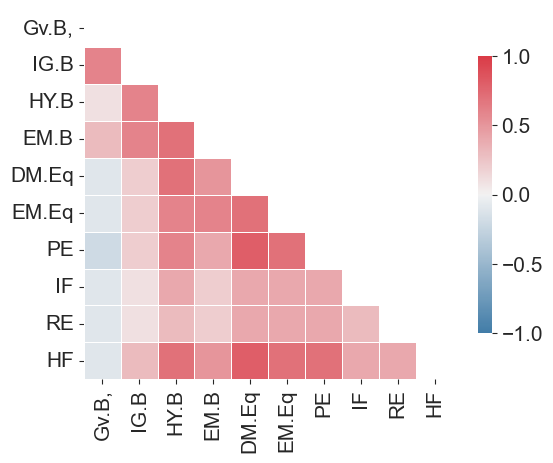

In [4]:
correlation_plot(C,names=asset_list)
print(asset_list)
print("Target Returns, µ = {} ".format(mu*100))

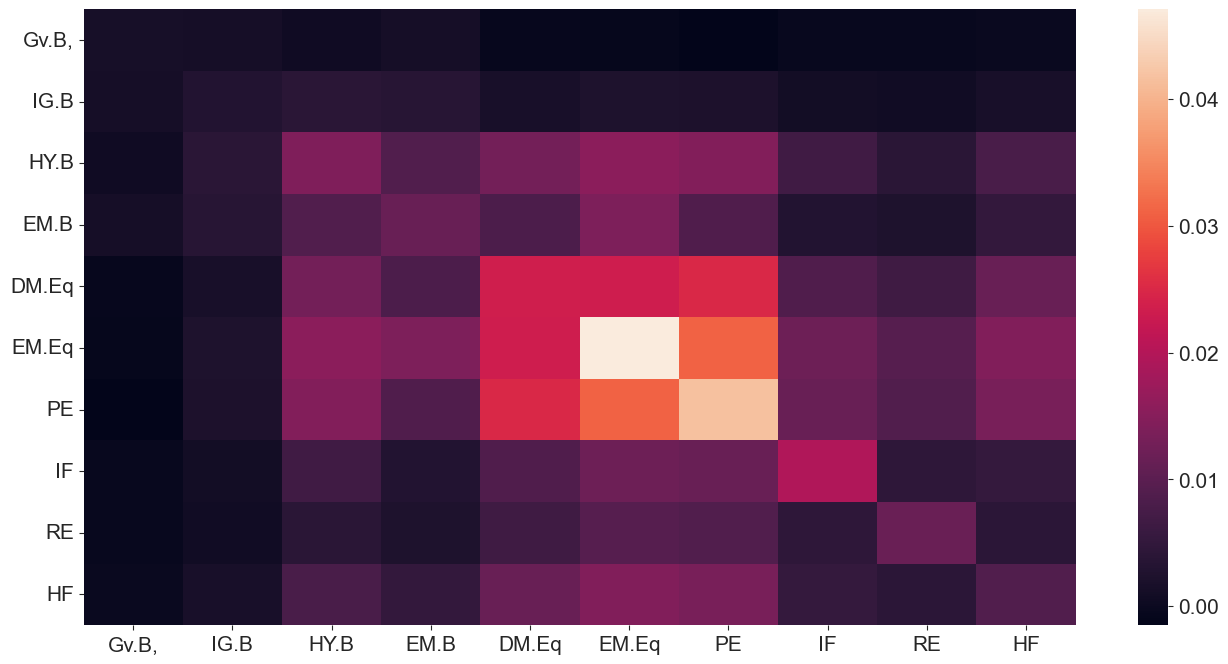

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(Sigma, xticklabels=asset_list, yticklabels=asset_list);


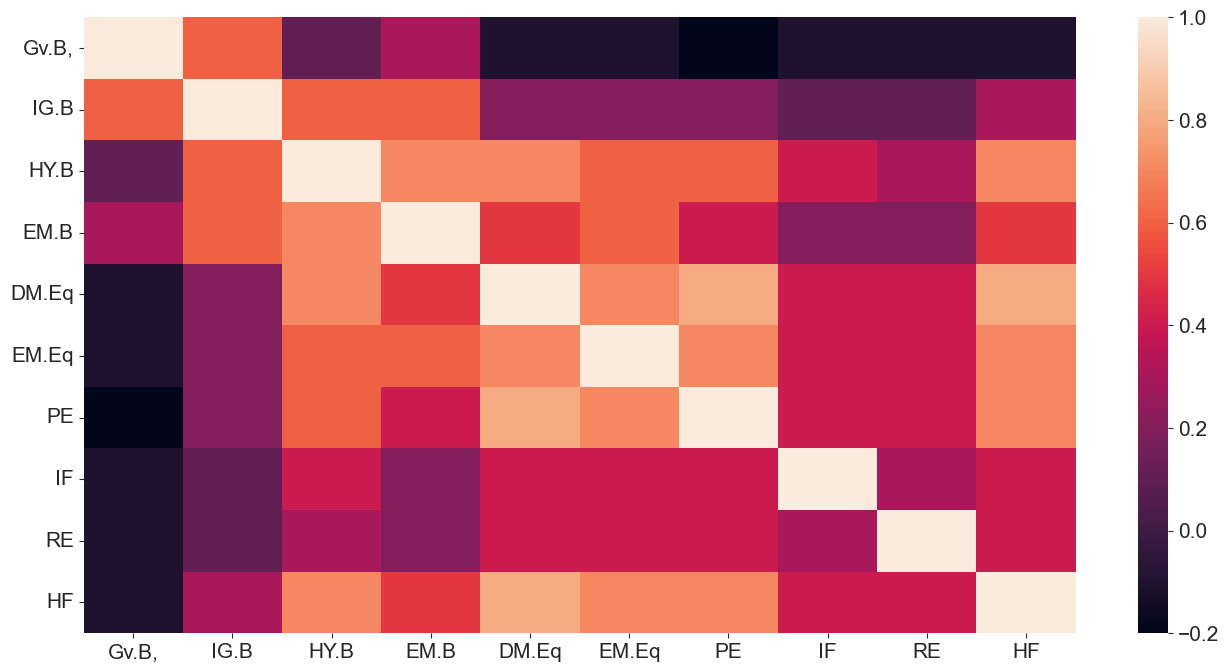

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(C, xticklabels=asset_list, yticklabels=asset_list);


In [7]:
pd_Sigma=pd.DataFrame(Sigma)
pd_Sigma.columns = asset_list
pd_Sigma.index = asset_list

pd_mu = pd.DataFrame(mu).T
pd_mu.columns = asset_list

In [8]:
pd_Sigma

,"Gv.B,",IG.B,HY.B,EM.B,DM.Eq,EM.Eq,PE,IF,RE,HF
"Gv.B,",0.001369,0.001221,0.000440,0.001188,-0.000566,-0.000803,-0.001510,-0.000518,-0.000400,-0.000348
IG.B,0.001221,0.003025,0.003927,0.003531,0.001683,0.002387,0.002244,0.000770,0.000594,0.001551
HY.B,0.000440,0.003927,0.014161,0.008913,0.012745,0.015494,0.014566,0.006664,0.003856,0.007830
EM.B,0.001188,0.003531,0.008913,0.011449,0.008186,0.013931,0.008731,0.002996,0.002311,0.005029
DM.Eq,-0.000566,0.001683,0.012745,0.008186,0.023409,0.023241,0.024970,0.008568,0.006610,0.011506
EM.Eq,-0.000803,0.002387,0.015494,0.013931,0.023241,0.047089,0.030988,0.012152,0.009374,0.014279
PE,-0.001510,0.002244,0.014566,0.008731,0.024970,0.030988,0.041616,0.011424,0.008813,0.013423
IF,-0.000518,0.000770,0.006664,0.002996,0.008568,0.012152,0.011424,0.019600,0.004536,0.005264
RE,-0.000400,0.000594,0.003856,0.002311,0.006610,0.009374,0.008813,0.004536,0.011664,0.004061
HF,-0.000348,0.001551,0.007830,0.005029,0.011506,0.014279,0.013423,0.005264,0.004061,0.008836


In [9]:
pd_mu

,"Gv.B,",IG.B,HY.B,EM.B,DM.Eq,EM.Eq,PE,IF,RE,HF
0,0.018315,0.020487,0.04192,0.037275,0.049295,0.059456,0.081192,0.0462,0.035168,0.033582


## Functions: $\mu \rightarrow \mu^L, \Sigma \rightarrow \Sigma^L$

In [10]:
def calculate_mu_l(mu: np.ndarray, covariance: np.ndarray) -> np.ndarray: 
    
    """
    Function that calculates the expected value of the linear return vector, 
    when log-returns are normally distributed
    
    Parameters
    ----------
    mu: 
        Vector of expected log returns
    covariance: 
        Covariance matrix of log returns
    
    Returns
    -------
    float
        Expected value of linear return vector 
    """
    
    #return np.exp(mu + 0.5*np.diag(covariance)) - 1
    return np.exp(mu + 0.5*np.diag(covariance)) 

def calculate_sigma_l(mu: np.ndarray, covariance: np.ndarray) -> np.ndarray: 
    
    """
    Function that calculates the covariance matrix of the linear return vector, 
    when log-returns are normally distributed
    
    Parameters
    ----------
    mu: 
        Vector of expected log returns
    covariance: 
        Covariance matrix of log returns
    
    Returns
    -------
    float
        Covariance matrix of linear return vector 
    """
    
    #mu_l = calculate_mu_l(mu, covariance) + 1
    mu_l = calculate_mu_l(mu, covariance)
    
    return np.outer(mu_l, mu_l) * (np.exp(covariance) - 1)

# $t = 0$: Initial Portfolio:  Investor holds equally weighted Portfolio

$ W_0 = \alpha_0^T P_0 $

In [11]:
# Initial Wealth

W0 = 5000000

#Amount of Asset Classes

N = 10

#Initial Asset Prices, P0

P0 = np.ones(N)

#Initial Asset Weights/Holdings, alpha0 -- Equally Weighted

alpha0 = W0 *  np.ones(N)/N


### Investor seeks to optimize allocation, $\alpha \geq 0$ -- buy and hold for the next 5 years

yearly compound / log-returns are iid multivariate normally distributed:
$r_{t+1,1} \sim MVN(\mu, \Sigma)$

https://towardsdatascience.com/log-normal-distribution-a-simple-explanation-7605864fb67c

https://www.isi-web.org/isi.cbs.nl/iamamember/CD2/pdf/329.PDF

https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf

### Distribution of Vector of asset prices in 5 Years, $\boldsymbol{P}_5 \sim LogN(5\boldsymbol{\mu}, 5\boldsymbol{\Sigma})$

In [12]:
#estimation interval is yearly --> dt = 1
dt = 1.0 / 1.0
tau = 5

# five year projection of expected return and covariance for log returns
mu_5y = tau / dt * mu 
Sigma_5y = tau / dt * Sigma

print("5µ = {} ".format(pd.DataFrame(mu_5y).T))
print("5∑ = {} ".format(pd.DataFrame(Sigma_5y)))

5µ =           0         1         2         3         4         5        6      7  \
0  0.091577  0.102437  0.209598  0.186377  0.246477  0.297278  0.40596  0.231   

         8        9  
0  0.17584  0.16791   
5∑ =           0         1         2         3         4         5         6  \
0  0.006845  0.006105  0.002202  0.005938 -0.002830 -0.004015 -0.007548   
1  0.006105  0.015125  0.019635  0.017655  0.008415  0.011935  0.011220   
2  0.002202  0.019635  0.070805  0.044565  0.063724  0.077469  0.072828   
3  0.005938  0.017655  0.044565  0.057245  0.040927  0.069657  0.043656   
4 -0.002830  0.008415  0.063724  0.040927  0.117045  0.116204  0.124848   
5 -0.004015  0.011935  0.077469  0.069657  0.116204  0.235445  0.154938   
6 -0.007548  0.011220  0.072828  0.043656  0.124848  0.154938  0.208080   
7 -0.002590  0.003850  0.033320  0.014980  0.042840  0.060760  0.057120   
8 -0.001998  0.002970  0.019278  0.011556  0.033048  0.046872  0.044064   
9 -0.001739  0.007755  0.039151 

In [13]:
np.round(mu_5y,4)

array([0.0916, 0.1024, 0.2096, 0.1864, 0.2465, 0.2973, 0.406 , 0.231 ,
       0.1758, 0.1679])

In [14]:
np.round(Sigma_5y,4)

array([[ 0.0068,  0.0061,  0.0022,  0.0059, -0.0028, -0.004 , -0.0075,
        -0.0026, -0.002 , -0.0017],
       [ 0.0061,  0.0151,  0.0196,  0.0177,  0.0084,  0.0119,  0.0112,
         0.0039,  0.003 ,  0.0078],
       [ 0.0022,  0.0196,  0.0708,  0.0446,  0.0637,  0.0775,  0.0728,
         0.0333,  0.0193,  0.0392],
       [ 0.0059,  0.0177,  0.0446,  0.0572,  0.0409,  0.0697,  0.0437,
         0.015 ,  0.0116,  0.0251],
       [-0.0028,  0.0084,  0.0637,  0.0409,  0.117 ,  0.1162,  0.1248,
         0.0428,  0.033 ,  0.0575],
       [-0.004 ,  0.0119,  0.0775,  0.0697,  0.1162,  0.2354,  0.1549,
         0.0608,  0.0469,  0.0714],
       [-0.0075,  0.0112,  0.0728,  0.0437,  0.1248,  0.1549,  0.2081,
         0.0571,  0.0441,  0.0671],
       [-0.0026,  0.0039,  0.0333,  0.015 ,  0.0428,  0.0608,  0.0571,
         0.098 ,  0.0227,  0.0263],
       [-0.002 ,  0.003 ,  0.0193,  0.0116,  0.033 ,  0.0469,  0.0441,
         0.0227,  0.0583,  0.0203],
       [-0.0017,  0.0078,  0.0392,  0

In [15]:
str(np.round(Sigma_5y,4)).replace(",","")

'[[ 0.0068  0.0061  0.0022  0.0059 -0.0028 -0.004  -0.0075 -0.0026 -0.002\n  -0.0017]\n [ 0.0061  0.0151  0.0196  0.0177  0.0084  0.0119  0.0112  0.0039  0.003\n   0.0078]\n [ 0.0022  0.0196  0.0708  0.0446  0.0637  0.0775  0.0728  0.0333  0.0193\n   0.0392]\n [ 0.0059  0.0177  0.0446  0.0572  0.0409  0.0697  0.0437  0.015   0.0116\n   0.0251]\n [-0.0028  0.0084  0.0637  0.0409  0.117   0.1162  0.1248  0.0428  0.033\n   0.0575]\n [-0.004   0.0119  0.0775  0.0697  0.1162  0.2354  0.1549  0.0608  0.0469\n   0.0714]\n [-0.0075  0.0112  0.0728  0.0437  0.1248  0.1549  0.2081  0.0571  0.0441\n   0.0671]\n [-0.0026  0.0039  0.0333  0.015   0.0428  0.0608  0.0571  0.098   0.0227\n   0.0263]\n [-0.002   0.003   0.0193  0.0116  0.033   0.0469  0.0441  0.0227  0.0583\n   0.0203]\n [-0.0017  0.0078  0.0392  0.0251  0.0575  0.0714  0.0671  0.0263  0.0203\n   0.0442]]'

### Expected Value and Covariance of asset prices in 5 years?

In [16]:
#five year projection of linear returns

mu_5y_l = calculate_mu_l(mu_5y, Sigma_5y)
Sigma_5y_l = calculate_sigma_l(mu_5y, Sigma_5y)
#print("Expected Value of Asset Prices in 5 Years, µ_5 = {} ".format(pd.DataFrame(mu_5y_l).T))
#print("Expected Covariance of Asset Prices in 5 Years, ∑_5 = {} ".format(pd.DataFrame(Sigma_5y_l)))

In [17]:
np.round(mu_5y_l,4)

array([1.0997, 1.1163, 1.2776, 1.2399, 1.3566, 1.5144, 1.6653, 1.3231,
       1.2275, 1.2092])

In [18]:
str(np.round(Sigma_5y_l,4)).replace(",","&").replace("\n","")

'[[ 0.0083  0.0075  0.0031  0.0081 -0.0042 -0.0067 -0.0138 -0.0038 -0.0027  -0.0023] [ 0.0075  0.019   0.0283  0.0247  0.0128  0.0203  0.021   0.0057  0.0041   0.0105] [ 0.0031  0.0283  0.1198  0.0722  0.114   0.1558  0.1607  0.0573  0.0305   0.0617] [ 0.0081  0.0247  0.0722  0.0906  0.0703  0.1355  0.0921  0.0248  0.0177   0.0382] [-0.0042  0.0128  0.114   0.0703  0.2285  0.2532  0.3004  0.0786  0.056   0.0971] [-0.0067  0.0203  0.1558  0.1355  0.2532  0.6088  0.4226  0.1255  0.0892   0.1355] [-0.0138  0.021   0.1607  0.0921  0.3004  0.4226  0.6415  0.1295  0.0921   0.1398] [-0.0038  0.0057  0.0573  0.0248  0.0786  0.1255  0.1295  0.1803  0.0373   0.0427] [-0.0027  0.0041  0.0305  0.0177  0.056   0.0892  0.0921  0.0373  0.0905   0.0304] [-0.0023  0.0105  0.0617  0.0382  0.0971  0.1355  0.1398  0.0427  0.0304   0.0661]]'

### Visualize evolution of wealth for the next five years using initial allocation -- Simulated Prices

in order to visualize the wealth evolution I simulate some lognormally distributed prices simulating some log returns with the properties given and plot the buy and hold strategy for those across different confidens intervals

In [19]:
# number of simulations 
num_sim = 10000
dt = 1
horizon = 5 
time_points = np.arange(0.0, horizon + 0.01, dt)
print(time_points)

[0. 1. 2. 3. 4. 5.]


In [20]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices since P0 = 1 otherwise scaling would be necessary
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices, log_ret

In [21]:
sim_asset_prices, sim_log_ret  = simulate_asset_prices(mu, Sigma, horizon, dt, num_sim)

In [22]:
sim_asset_prices.shape, sim_log_ret.shape

((10000, 6, 10), (10000, 5, 10))

In [23]:
np.mean(sim_asset_prices[:,-1,:], axis = 0)

array([1.10021163, 1.11748349, 1.28342982, 1.24496603, 1.36204897,
       1.52926273, 1.67121249, 1.32364374, 1.22995036, 1.21537224])

 ...]

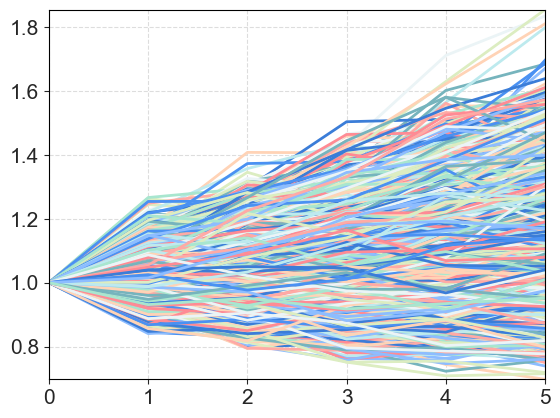

In [24]:
plt.plot(np.arange(0,6),sim_asset_prices[:,:,1].T)

In [25]:
np.mean(sim_asset_prices[:,-1,:],axis = 0)

array([1.10021163, 1.11748349, 1.28342982, 1.24496603, 1.36204897,
       1.52926273, 1.67121249, 1.32364374, 1.22995036, 1.21537224])

In [1602]:
np.mean(sim_asset_prices[:,-1,:],axis = 0)

array([1.10063135, 1.11629361, 1.2815661 , 1.24299697, 1.36132386,
       1.51638409, 1.65968272, 1.33095348, 1.22905159, 1.20846201])

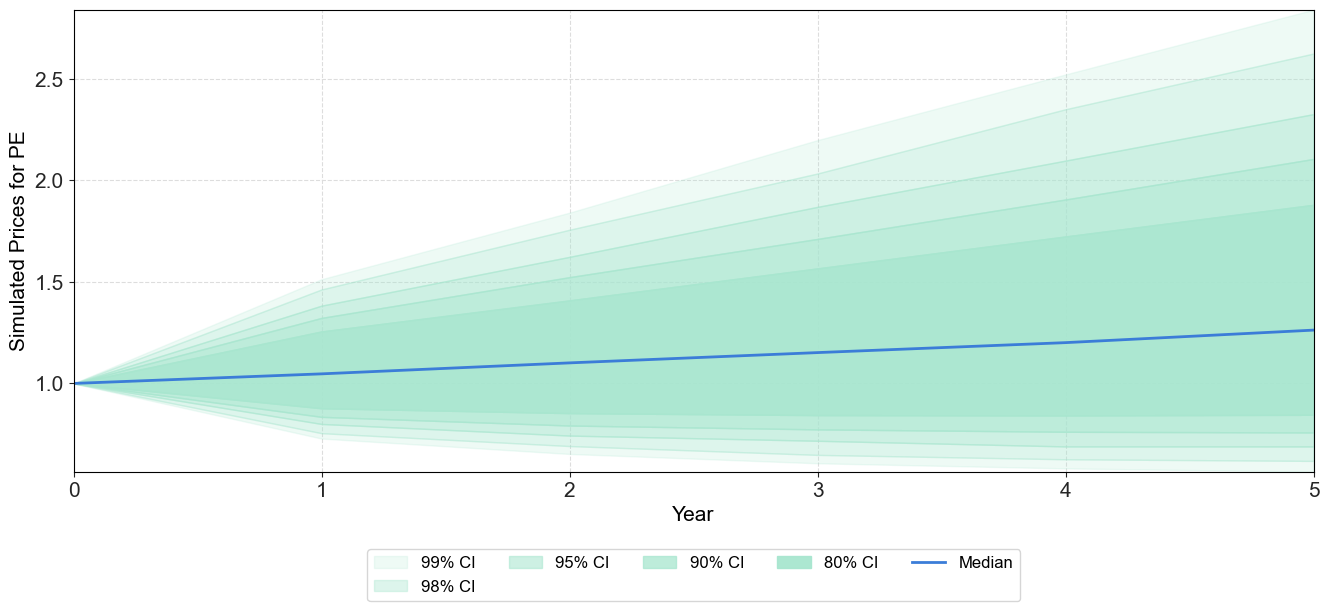

In [26]:
# calculate percentiles
plot_prices = np.percentile(sim_asset_prices[:,:,7], [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)


"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(16, 6))

fan_chart(time_points,
          #percentiles_buy_and_hold/W0,
          plot_prices,
          color=default_colors['green'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Simulated Prices for PE", size=15)
#ax.set_title("Buy and Hold", size=15)
#ax.set_ylim([0.5, 2.5])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12)

__Linear Returns__

In [27]:
mu_l = calculate_mu_l(mu, Sigma)
mu_5y_l
Sigma_l = calculate_sigma_l(mu, Sigma)
Sigma_5y_l;

In [28]:
pd.DataFrame(mu_5y_l).T

,0,1,2,3,4,5,6,7,8,9
0,1.099659,1.116278,1.277621,1.239862,1.356625,1.514371,1.665291,1.32313,1.227525,1.20925


In [29]:
pd.DataFrame(Sigma_5y_l)

,0,1,2,3,4,5,6,7,8,9
0,0.008306,0.007517,0.003096,0.008121,-0.004217,-0.006672,-0.013770,-0.003764,-0.002694,-0.002310
1,0.007517,0.018990,0.028280,0.024652,0.012797,0.020297,0.020975,0.005697,0.004076,0.010509
2,0.003096,0.028280,0.119766,0.072192,0.114046,0.155845,0.160732,0.057275,0.030527,0.061687
3,0.008121,0.024652,0.072192,0.090568,0.070269,0.135452,0.092134,0.024760,0.017690,0.038178
4,-0.004217,0.012797,0.114046,0.070269,0.228526,0.253156,0.300417,0.078568,0.055954,0.097142
5,-0.006672,0.020297,0.155845,0.135452,0.253156,0.608811,0.422629,0.125520,0.089206,0.135519
6,-0.013770,0.020975,0.160732,0.092134,0.300417,0.422629,0.641472,0.129522,0.092089,0.139794
7,-0.003764,0.005697,0.057275,0.024760,0.078568,0.125520,0.129522,0.180254,0.037257,0.042671
8,-0.002694,0.004076,0.030527,0.017690,0.055954,0.089206,0.092089,0.037257,0.090491,0.030447
9,-0.002310,0.010509,0.061687,0.038178,0.097142,0.135519,0.139794,0.042671,0.030447,0.066052


#### Plots

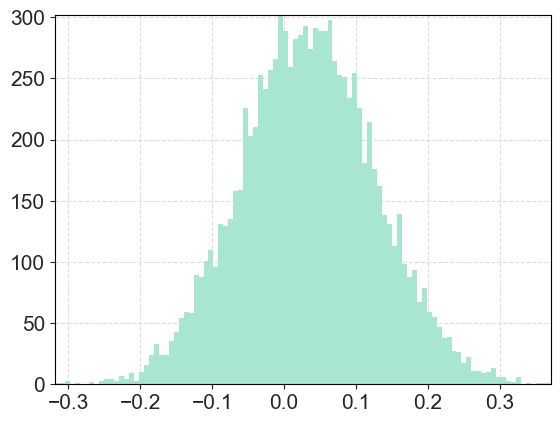

In [30]:
plt.hist(sim_log_ret[:,4, 9], bins=100);

### Wealth Visualization -- Initial Portfolio: $P \cdot \alpha_0$

In [32]:
"""
Buy and hold strategy for initial portfolio
"""


# Wealth Portfolios (across all simulation paths)

init_buy_and_hold_index = sim_asset_prices @ alpha0
init_buy_and_hold_index.shape

#init_buy_and_hold_index/W0 

(10000, 6)

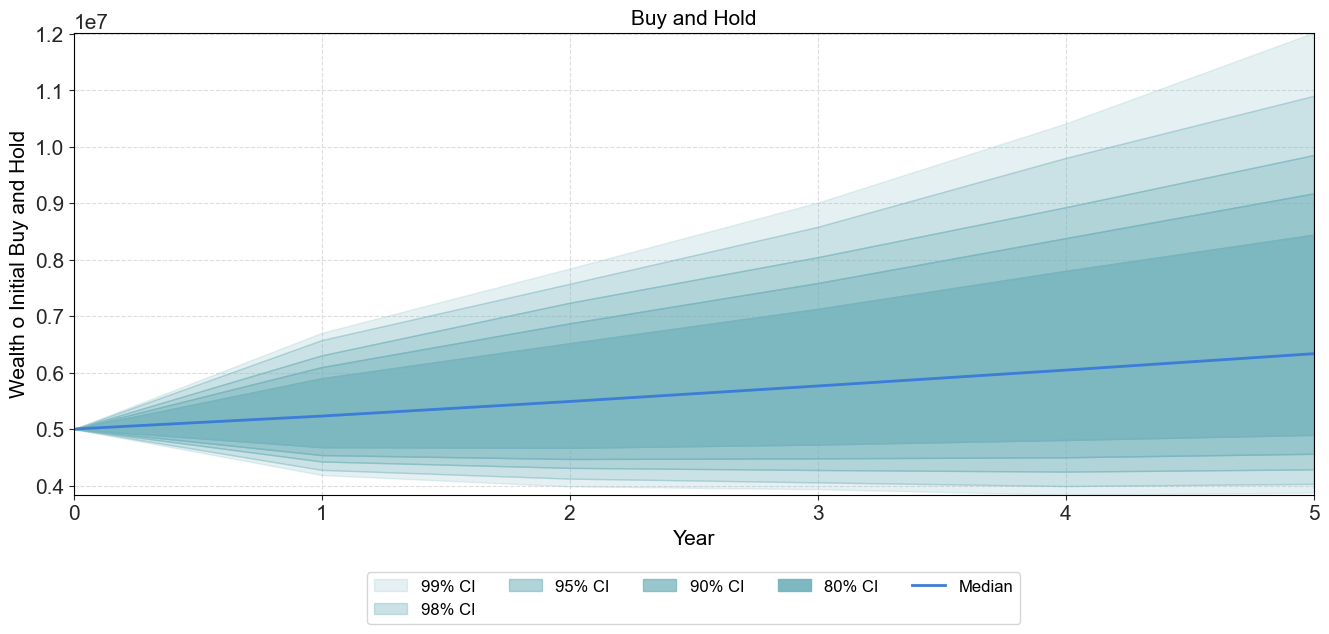

In [33]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(init_buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)


"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(16, 6))

fan_chart(time_points,
          #percentiles_buy_and_hold/W0,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Wealth o Initial Buy and Hold", size=15)
ax.set_title("Buy and Hold", size=15)
#ax.set_ylim([0.5, 2.5])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12)

# Use minimum variance optimization for optimal allocation (max expected wealth for given var/std target OR min expected var for given wealth target)

### Linear Transaction costs & Power Utility Function -- Satisfaction Measure

Linear transactions costs

$$
T(\boldsymbol{\alpha}_0, \boldsymbol{\alpha})=\boldsymbol{k}^T|\boldsymbol{\alpha}_0 - \boldsymbol{\alpha}|
$$

meaning if the investor buys it pays the volume change per position times a positive scalar (price), $\boldsymbol{k}$ per asset

In [34]:
#Transaction Costs

#k = np.ones(N)/50
#print(pd.DataFrame(k).T)

k = 0.02

# Risk aversion

gam = -9

plot of linear transaction costs for a single asset (possible positions: $[0,1]$ meaning either we hold nothing or the entire portfolio in a given asset)

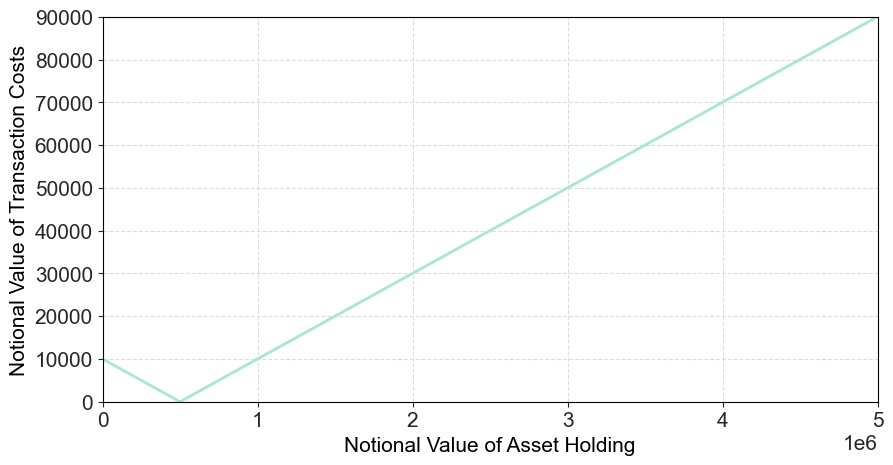

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0,W0+1,1000), k*abs(alpha0[1]-np.arange(0,W0+1,1000)))
#ax.set_title('Transaction Costs for Asset $i$, T($α_0, α$), α $\in$ [0, 5.000.000]')
ax.set_ylabel('Notional Value of Transaction Costs');
ax.set_xlabel('Notional Value of Asset Holding');

### Theory (Modern Portfolio Theory) -- Optimization Problem

Generally the target is to maximize the following:



### Write up optimization problem when taking into account relevant constraints

### Simulation plots

Text(0, 0.5, 'Asset Prices, $P$')

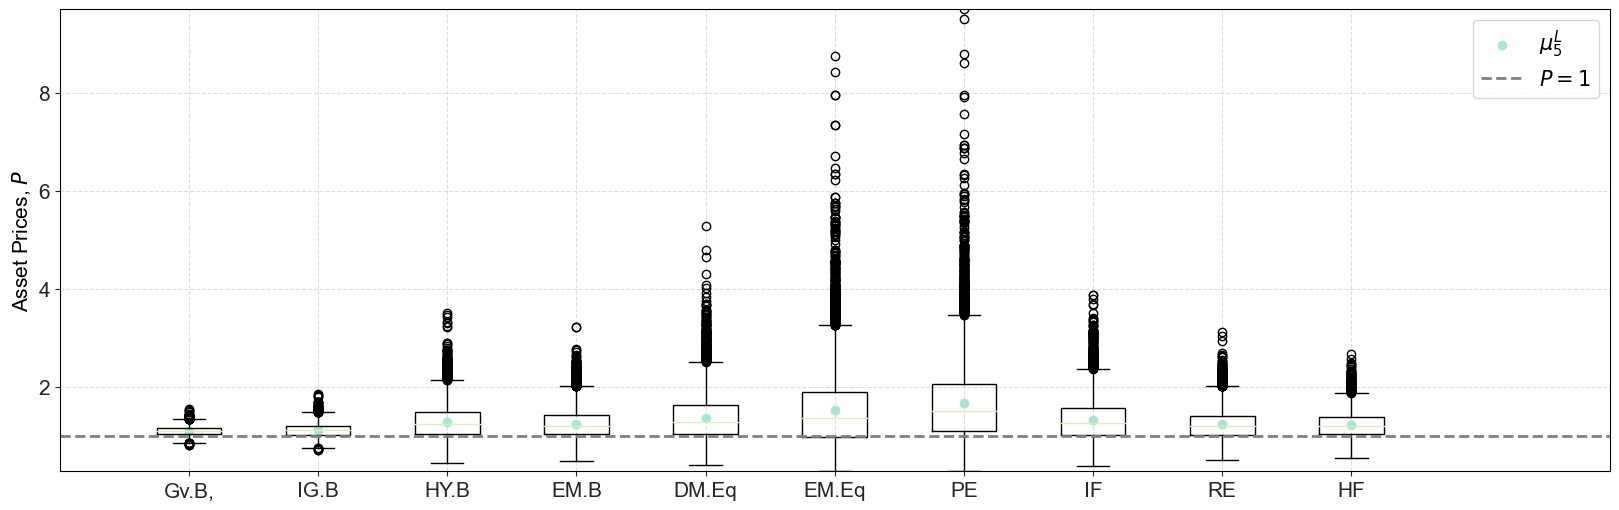

In [36]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.boxplot(sim_asset_prices[:,-1,:]); 

#ax.set_xticklabels(["Asset {}".format(_) for _ in asset_list])

ax.set_xticklabels(["{}".format(_) for _ in asset_list])
ax.scatter(np.arange(1,11),mu_5y_l, label="$\mu_5^L$")
ax.hlines(y=1,color='grey',xmin=asset_list[0],xmax=len(asset_list)+2, linestyles='--', label="$P = 1$")
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
#ax.set_ylim([0, 1.0])

ax.legend();
ax.set_ylabel("Asset Prices, $P$")
#ax.set_title("Distribution of Simulated Asset Prices Compared to $\mu_5^L$");

### Solve opt.problem for range of std/var targets or wealth targets p. 354

In [37]:
print(sim_asset_prices.shape)
Wbar = np.mean(1+2*(np.mean(sim_asset_prices[:,-1,:], axis=0)-1),axis=0)
#Wbar = sim_asset_prices[:,-1,:]@alpha0
#Prices of each asset in Y5, where the range in the optimization becomes the smallest price · W0 to the largest price · W0
#Wbar = sim_asset_prices[:,-1,:]
Wbar.shape
Wbar*W0
print(np.max(Wbar),Wbar)
np.percentile(sim_asset_prices[:,-1,:],0.50)

(10000, 6, 10)
1.6155162982232618 1.6155162982232618


0.5364197267270902

In [38]:
pf_mean0 = portfolio_mean(alpha0, mu_5y_l)   #alpha0 @ mu_5y_l
pf_cov0 = portfolio_variance(alpha0, Sigma_5y_l) # alpha0 @ Sigma_5y_l @ alpha0
print(pf_mean0)
print(pf_cov0)

6514805.7746789735
2099941803045.4492


In [39]:
# number of simulations 
num_sim = 10000
dt = 1
horizon = 5 
time_points = np.arange(0.0, horizon + 0.01, dt)
print(time_points)

#estimation interval is yearly --> dt = 1
dt = 1.0 / 1.0
tau = 5

# five year projection of expected return and covariance for log returns
mu_5y = tau / dt * mu 
Sigma_5y = tau / dt * Sigma

#five year projection of linear returns

mu_5y_l = calculate_mu_l(mu_5y, Sigma_5y)
Sigma_5y_l = calculate_sigma_l(mu_5y, Sigma_5y)

#one  year conversions of linear returns
mu_l = calculate_mu_l(mu, Sigma)
Sigma_l = calculate_sigma_l(mu, Sigma);

[0. 1. 2. 3. 4. 5.]


In [41]:
print(np.mean(mu_5y_l,axis=0))

1.302961154935795


In [42]:
P5=np.mean(sim_asset_prices[:,-1,:],axis=0)
P5.shape
print(np.min(P0)*W0, np.max(Wbar)*W0)
print(np.min(P0), np.max(Wbar))

5000000.0 8077581.49111631
1.0 1.6155162982232618


In [43]:
mu_5y_l*W0

array([5498294.27563051, 5581390.35229436, 6388106.56602443,
       6199309.48483031, 6783125.01503112, 7571853.70346024,
       8326455.97472943, 6615649.06168718, 6137625.32481589,
       6046247.98828626])

Absolute Setup -- Final

In [44]:
"""
Define relevant constraints -- FINAL | ABSOLUTES
"""
k=0.02
alpha0_w = alpha0/W0

#sum_to_one_cons = {'type': 'eq',
#                   'fun' : lambda x: np.sum(x/(W0 - (k*abs(alpha0-x)).sum())) - 1} 
                   #,'jac' : lambda x: np.ones_like(x)}#-k*np.ones_like(x)}
                   

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x
                ,'jac' : lambda x: np.eye(len(x))}

#budget_cons = {'type': 'ineq',
budget_cons = {'type': 'eq',
                  #  'fun' : lambda x: W0 - W0*k*np.sum(abs(alpha0_w - x)) - np.sum( W0 * x )}
                  #  'fun' : lambda x: 1 - np.sum( k * abs( alpha0_w - x )) - x #}
                   #'fun' : lambda x: (W0 * x).sum() - (alpha0[0] - W0 * k * abs( alpha0_w - x )).sum()}
                   #,'jac': lambda x: np.ones_like(x)-np.eye(len(x))}
                   'fun': lambda x: W0 - (k*abs(alpha0-x)).sum() - (x * P0).sum()
                    ,'jac': lambda x: -k*np.ones_like(x) - P0*np.ones_like(x)}
                  



#are actually prices --  depends on simulated data
target_returns = np.arange(np.min(P0)+0.1,np.max(Wbar), 0.01) * W0
#target_returns = np.arange(1.1,1.65, 0.01) * W0

optimal_weights = list()
trans_costs = list()

"""
Find optimal weights
"""
port_var_der = lambda w, cov_mat: 2 * w @ cov_mat
x0 = alpha0

for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   #'fun' : lambda x: x @ (mu_5y_l*W0) - target_return,
                   #'jac' : lambda x: mu_5y_l*W0 }
                   'fun' : lambda x: (x * (mu_5y_l)).sum() - target_return,
                   'jac' : lambda x: mu_5y_l}
 
                   
    res = optimize.minimize(portfolio_variance, x0=x0, args=(Sigma_5y_l,),
                                 method='SLSQP',
                                 jac=port_var_der,
                                 #constraints=[sum_to_one_cons, no_short_cons, budget_cons, target_cons], 
                                 constraints=[no_short_cons, budget_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': False})#, bounds=bounds)
    
    optimal_weights.append(res.x)
    trans_costs.append(k*(abs(alpha0 - res.x)).sum())
    #trans_costs.append(k*(abs(alpha0 - res.x)))
    
optimal_weights = np.array(optimal_weights)
trans_costs = np.array(trans_costs)


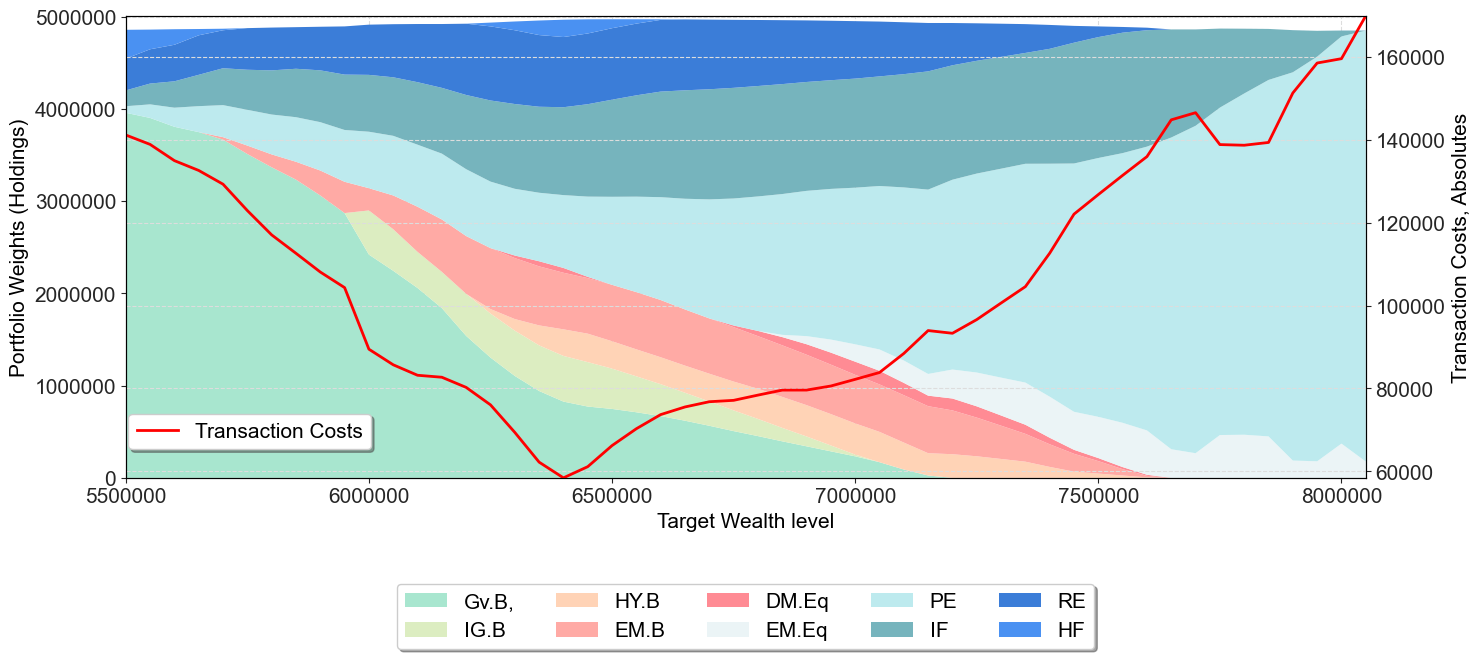

In [45]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=asset_list);
#ax.stackplot(target_returns, optimal_weights.T*100, labels=asset_list);
plt.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Target Wealth level")
ax.set_ylabel("Portfolio Weights (Holdings)")
#ax.set_title("Optimal Holdings, mean-variance at 5Y horizon")
#ax.set_xlim([np.floor(W0),np.ceil(W0*1.5)])
ax.set_ylim([np.floor(0),np.ceil(W0)+10000])
#ax.set_xlim([1,2])
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax_new = ax.twinx()
ax_new.plot(target_returns, trans_costs,  color="red", label = "Transaction Costs")
ax_new.legend(loc='center', bbox_to_anchor=(0.1, 0.1), fancybox=True, shadow=True, ncol=5);
ax_new.set_ylabel('Transaction Costs, Absolutes');

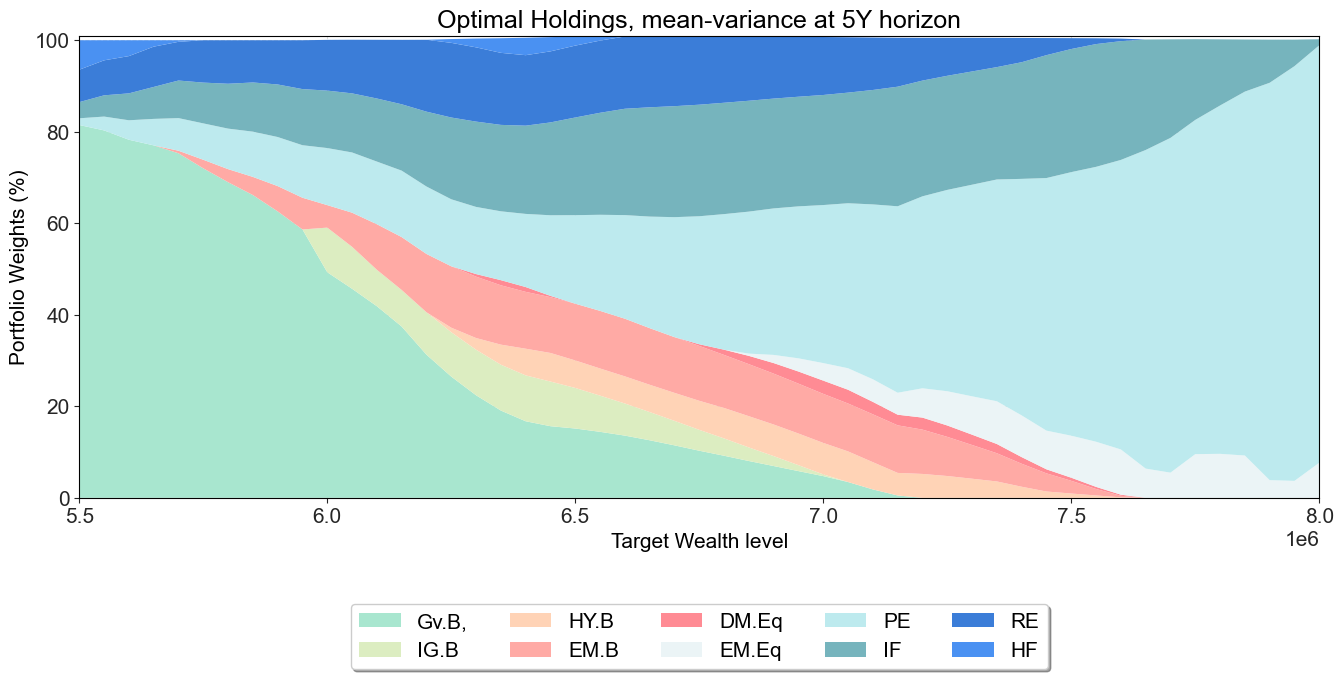

In [1585]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T/(W0-trans_costs)*100, labels=asset_list);
#ax.stackplot(target_returns, optimal_weights.T*100, labels=asset_list);
ax.set_xlabel("Target Wealth level")
ax.set_ylabel("Portfolio Weights (%)")
ax.set_title("Optimal Holdings, mean-variance at 5Y horizon")
#ax.set_xlim([W0,W0*1.5])
#ax.set_xlim([1,2])
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

#ax_new = ax.twinx()
#ax_new.plot(all_mu, all_port_cvar,  color="red")

Transaction Costs

In [1310]:
trans_costs.shape
#trans_costs_sum = np.sum(trans_costs, axis = 1)

Text(0.5, 0, 'Wealth Target')

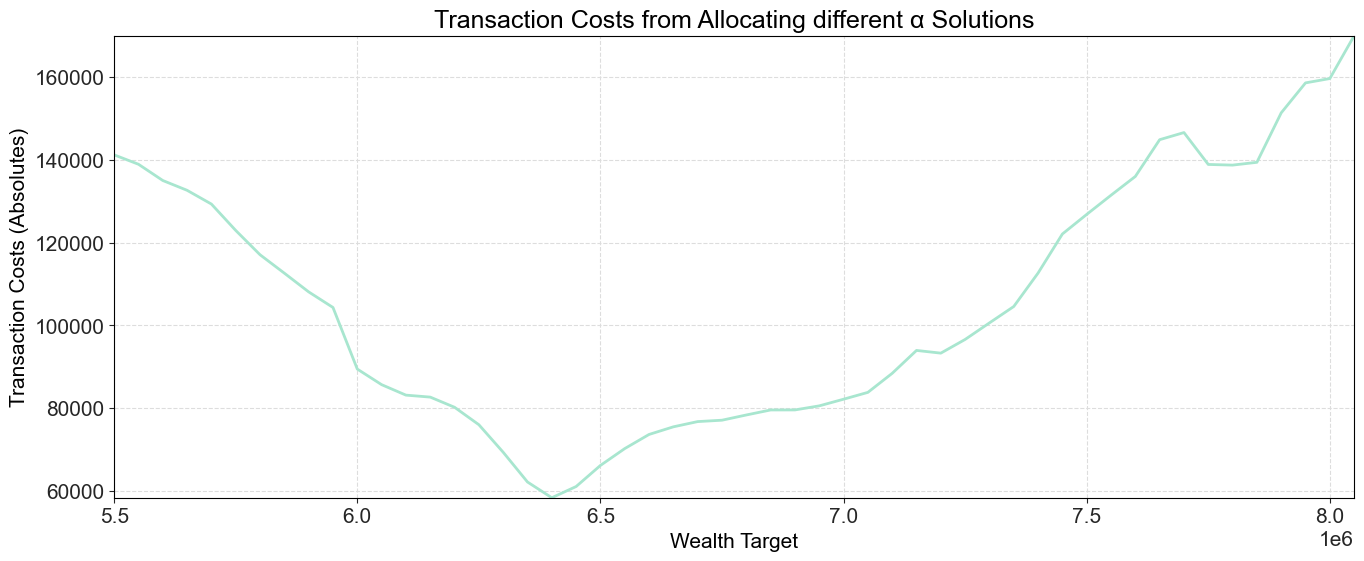

In [46]:
#plt.plot(trans_costs)
#plt.plot(np.round(trans_costs_sum,2))
#print(100*trans_costs[idxmax]/W0)
#trans_costs_notional = trans_costs*W0
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(target_returns, trans_costs)
ax.set_title('Transaction Costs from Allocating different α Solutions')
ax.set_ylabel('Transaction Costs (Absolutes)');
ax.set_xlabel("Wealth Target", size=15)


### Explain how to calculate satisfaction measure for each optimized portfolio and perform the calculations

To calculate this we follow p. 359: for each simulated price path we times each portfolio, sum over every price path and take the average of the paths

In [47]:
def utility(alpha, prices_vec, gamma: int = -9):
    return ((prices_vec @ alpha)**gamma) / gamma



def satisfaction(alpha, prices_df, gamma: int = -9):
    return ((gamma/prices_df.shape[0]) * np.sum(utility(alpha, prices_df[:,-1,:], gamma), axis = 0))**(1/gamma)

### What is optimal allocation given investors preferences? Present intuition and visualizations

In [48]:
utility(optimal_weights[1,:],sim_asset_prices[:,-1,:]).shape
satisfaction(optimal_weights[2,:],sim_asset_prices);

11
85711.06
4914288.939831433
       0     1    2     3    4    5      6      7      8    9
0  45.69  9.17  0.0  7.46  0.0  0.0  13.16  12.91  11.72  0.0


Text(0.5, 0, 'Wealth Target')

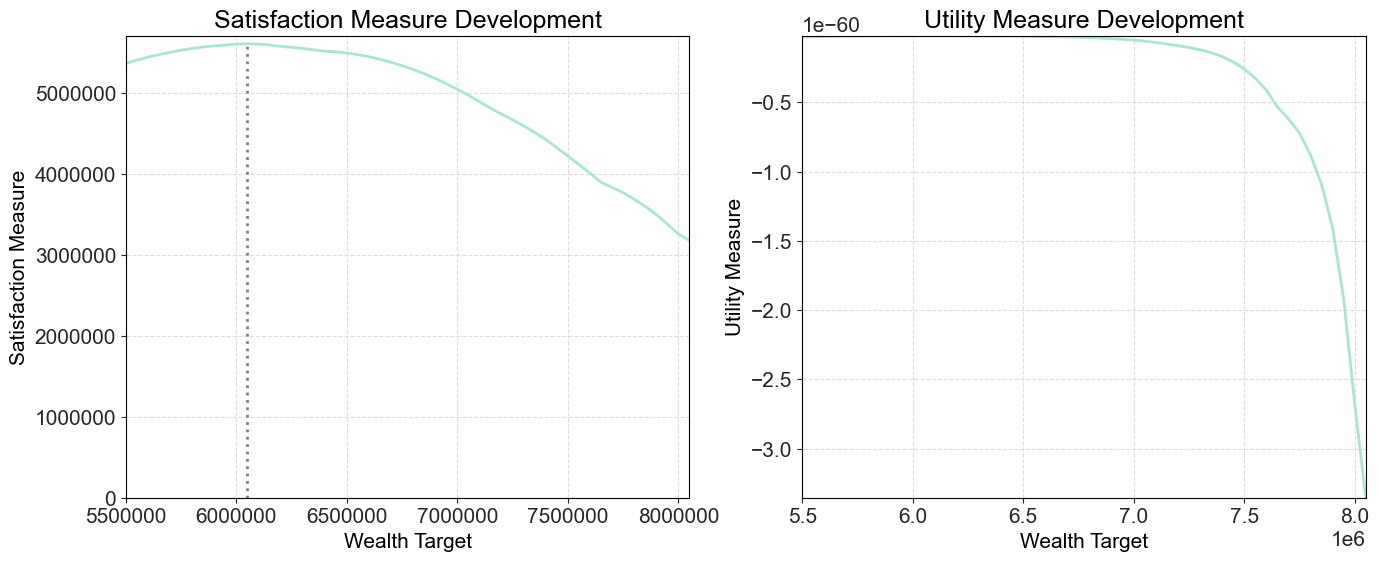

In [50]:
#target_returns = np.arange(np.min(Wbar),np.max(Wbar), 0.05) * W0
satisfaction_plot = np.ones(optimal_weights.shape[0])
utility_plot = np.ones(optimal_weights.shape[0])

for i in range(optimal_weights.shape[0]):
    satisfaction_plot[i] = satisfaction(optimal_weights[i,:],sim_asset_prices)
    utility_plot[i]=((1/sim_asset_prices.shape[0]) * np.sum(utility(optimal_weights[i,:], sim_asset_prices[:,-1,:]), axis = 0))

idxmax = np.argmax(satisfaction_plot)
print(idxmax)
opt_alpha = optimal_weights[idxmax]
#opt_alpha_w = optimal_weights[idxmax]/(W0-trans_costs_sum[idxmax])
opt_alpha_w = optimal_weights[idxmax]/(W0-trans_costs[idxmax])
print(round(trans_costs[idxmax],2))
print(W0-trans_costs[idxmax])
print(round(pd.DataFrame(opt_alpha_w*100).T,2))
sum(opt_alpha_w)

"""
Plot price development
"""
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].vlines(x=np.argmax(satisfaction_plot),color='grey',ymin=0,ymax=np.max(satisfaction_plot)+200, linestyles='--', label="$\alpha^*$")
ax[0].ticklabel_format(style='plain')
ax[0].plot(target_returns, satisfaction_plot)
ax[0].plot([opt_alpha@mu_5y_l, opt_alpha@mu_5y_l], [0, satisfaction_plot[idxmax]], color="grey", label = 'Optimized: Wealth Target', linestyle = 'dotted')
ax[0].set_title('Satisfaction Measure Development')
ax[0].set_ylabel('Satisfaction Measure');
ax[0].set_ylim([0,satisfaction_plot[idxmax]+100000]);
ax[0].set_xlabel("Wealth Target", size=15)


ax[1].plot(target_returns, utility_plot)
#ax[1].set_xticklabels(1,style='plain')
ax[1].set_title('Utility Measure Development')
ax[1].set_ylabel('Utility Measure');
ax[1].set_xlabel("Wealth Target", size=15)

optimal allocation is where satisfaction is  maximized

### Optimal portfolio

In [2173]:
idxmax = np.argmax(satisfaction_plot)
print(idxmax)
opt_alpha = optimal_weights[idxmax]
#opt_alpha_w = optimal_weights[idxmax]/(W0-trans_costs_sum[idxmax])
opt_alpha_w = optimal_weights[idxmax]/(W0-trans_costs[idxmax])
print(round(trans_costs[idxmax],2))
print(W0-trans_costs[idxmax])
print(round(pd.DataFrame(opt_alpha_w*100).T,2))
sum(opt_alpha_w)

11
85711.06
4914288.939831433
       0     1    2     3    4    5      6      7      8    9
0  45.69  9.17  0.0  7.46  0.0  0.0  13.16  12.91  11.72  0.0


1.0010797088289995

In [51]:
np.int0(satisfaction_plot[idxmax])

5609383

In [52]:
np.int0(pd.DataFrame(optimal_weights[idxmax]).T)

array([[2245432,  450563,       0,  366450,       1,       0,  646743,
         634584,  575813,       5]])

In [53]:
print("Optimal Wealth Target: ",mu_5y_l@opt_alpha)

Optimal Wealth Target:  6050000.000000001


## Visualize evolution of wealth for the next 5 years for opt.portfolio
### how does it compare with visualizations for initial portfolio?

In [55]:
"""
Buy and hold strategy for initial portfolio
"""


# Wealth Portfolios (across all simulation paths)

opt_buy_and_hold_index = sim_asset_prices @ opt_alpha
opt_buy_and_hold_index.shape

#init_buy_and_hold_index/W0 

(10000, 6)

In [56]:
print(opt_alpha.sum(axis=0))
print(alpha0.sum(axis=0))
print(opt_alpha.sum(axis=0)/alpha0.sum(axis=0))

4919594.940988022
5000000.0
0.9839189881976044


In [57]:
alpha0@mu_5y_l

6514805.7746789735

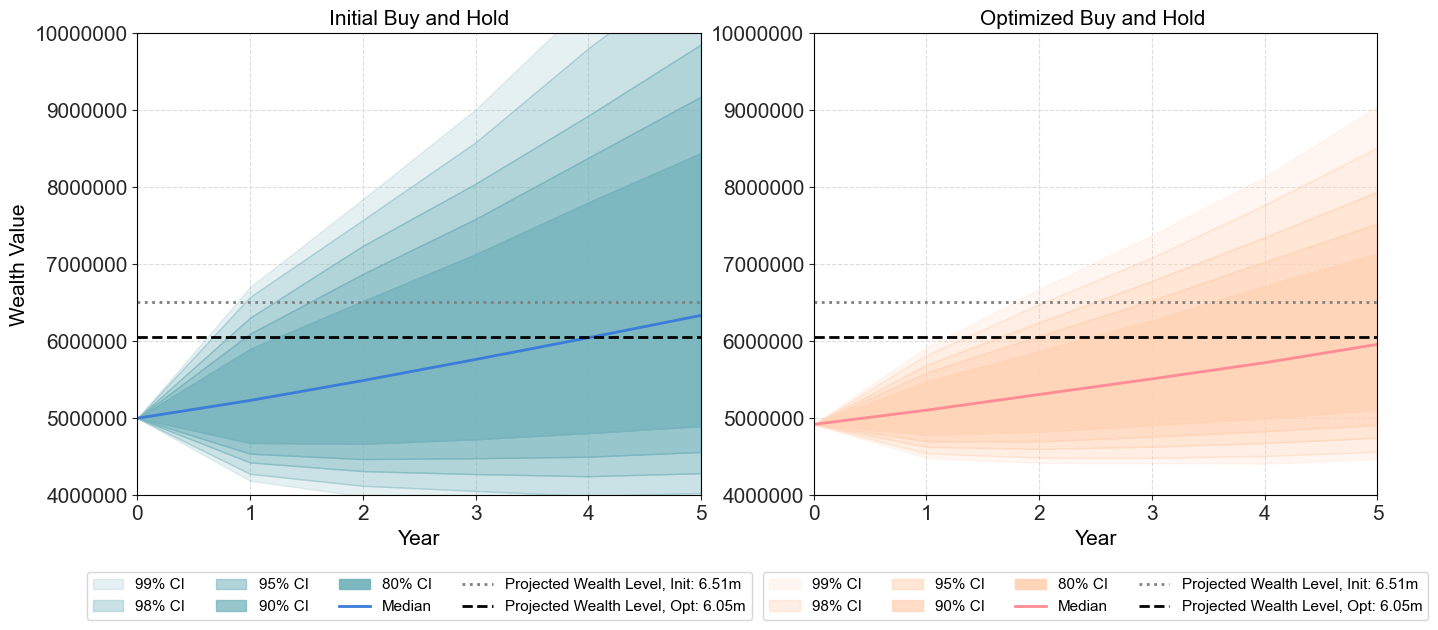

In [58]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(init_buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_opt_buy_and_hold = np.percentile(opt_buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""
#formatter = mtick.FormatStrFormatter("%1f.1")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Wealth Value", size=15)
ax[0].set_title("Initial Buy and Hold", size=15)
ax[0].ticklabel_format(style='plain')
ax[0].set_ylim([0.8*W0, 2*W0])
#ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].hlines(y=alpha0@mu_5y_l,color='grey',xmin=0,xmax=5, linestyles='dotted', label="Projected Wealth Level, Init: 6.51m")
ax[0].hlines(y=opt_alpha@mu_5y_l,color='black',xmin=0,xmax=5, linestyles='--', label="Projected Wealth Level, Opt: 6.05m")
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=11);



fan_chart(time_points,
          percentiles_opt_buy_and_hold,
          color=default_colors['orange'],
          color_median=default_colors['red'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Optimized Buy and Hold ", size=15)
ax[1].ticklabel_format(style='plain')
#ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[1].xaxis.set_major_formatter(formatter)
#ax[1].yaxis.set_major_formatter(formatter)
ax[1].set_ylim([0.8*W0, 2*W0])
ax[1].hlines(y=alpha0@mu_5y_l,color='grey',xmin=0,xmax=5, linestyles='dotted', label="Projected Wealth Level, Init: 6.51m")
ax[1].hlines(y=opt_alpha@mu_5y_l,color='black',xmin=0,xmax=5, linestyles='--', label="Projected Wealth Level, Opt: 6.05m")
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=11);

In [59]:
np.int0(opt_alpha)

array([2245432,  450563,       0,  366450,       1,       0,  646743,
        634584,  575813,       5])

In [60]:
np.round(opt_alpha_w,6)
opt_alpha_w.sum()

1.0010797088289993

Wealth Target  for the optimized and initial portfolio

In [61]:
#optimal portfolio
print("Opt:",opt_alpha@mu_5y_l)
#initial portfolio
print("Initial:",alpha0@mu_5y_l)

Opt: 6050000.000000001
Initial: 6514805.7746789735


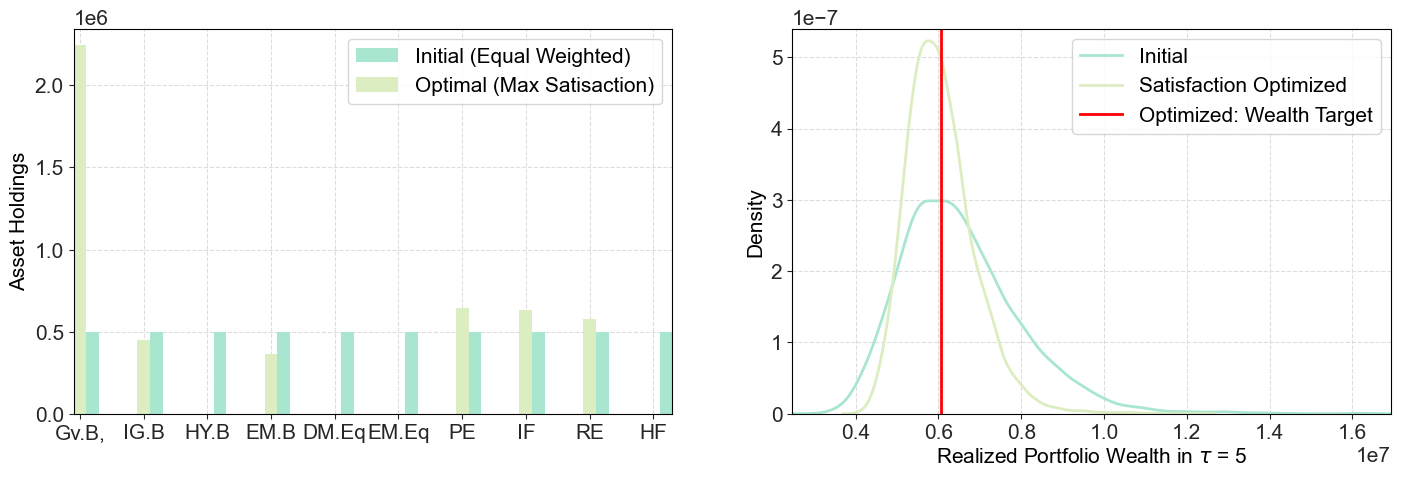

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].bar(np.arange(10)+0.2,alpha0, width=0.2, label="Initial (Equal Weighted)")
ax[0].bar(np.arange(10),opt_alpha, width=0.2, label="Optimal (Max Satisaction)")
ax[0].legend();
ax[0].set_ylabel("Allocation")
ax[0].set_ylabel("Asset Holdings")
ax[0].set_ylim([0.0, opt_alpha.max()+100000])
ax[0].set_xticks(np.arange(10), asset_list);


sns.kdeplot(init_buy_and_hold_index[:,-1], label="Initial");
sns.kdeplot(opt_buy_and_hold_index[:,-1], label="Satisfaction Optimized");
ax[1].plot([opt_alpha@mu_5y_l, opt_alpha@mu_5y_l], [0, 5.4*10**-7], color="red", label = 'Optimized: Wealth Target')
ax[1].set_xlabel("Realized Portfolio Wealth in $τ$ = 5");
ax[1].legend();

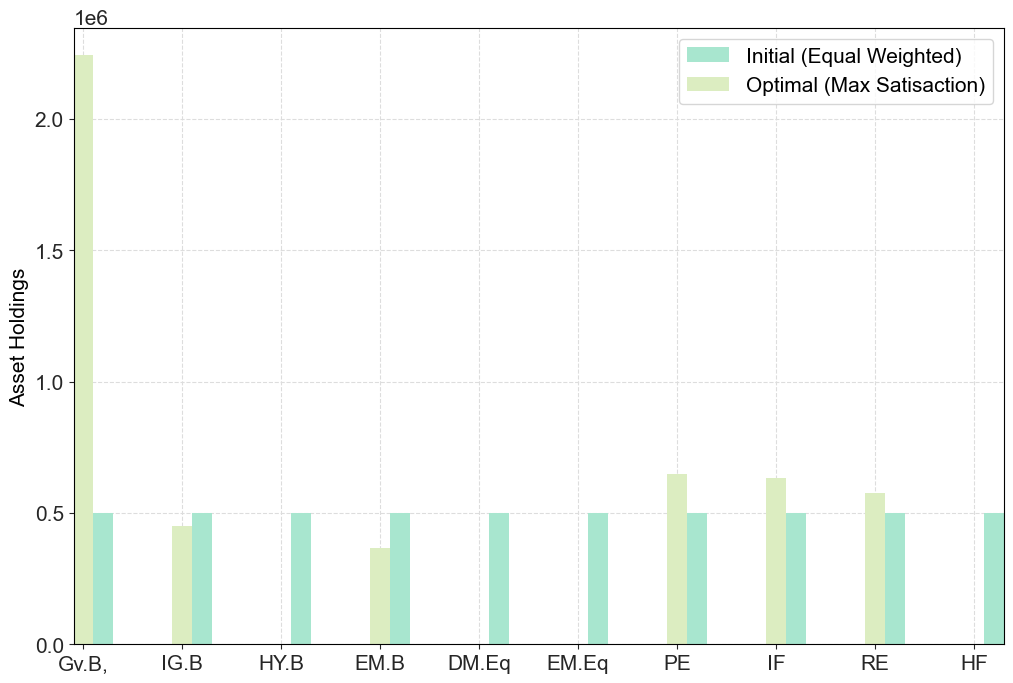

In [63]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(10)+0.2,alpha0, width=0.2, label="Initial (Equal Weighted)")
ax.bar(np.arange(10),opt_alpha, width=0.2, label="Optimal (Max Satisaction)")
#ax.hlines(y=W0,color='grey',xmin=asset_list[0],xmax=len(asset_list)+2, linestyles='--', label="$W_0 = 5m$")
ax.legend();
#ax.yaxis.set_major_formatter(mtick.MaxNLocator(integer=True));
ax.set_ylabel("Allocation")
ax.set_ylabel("Asset Holdings")
ax.set_ylim([0.0, opt_alpha.max()+100000])
plt.xticks(np.arange(10), asset_list);

Density Plot

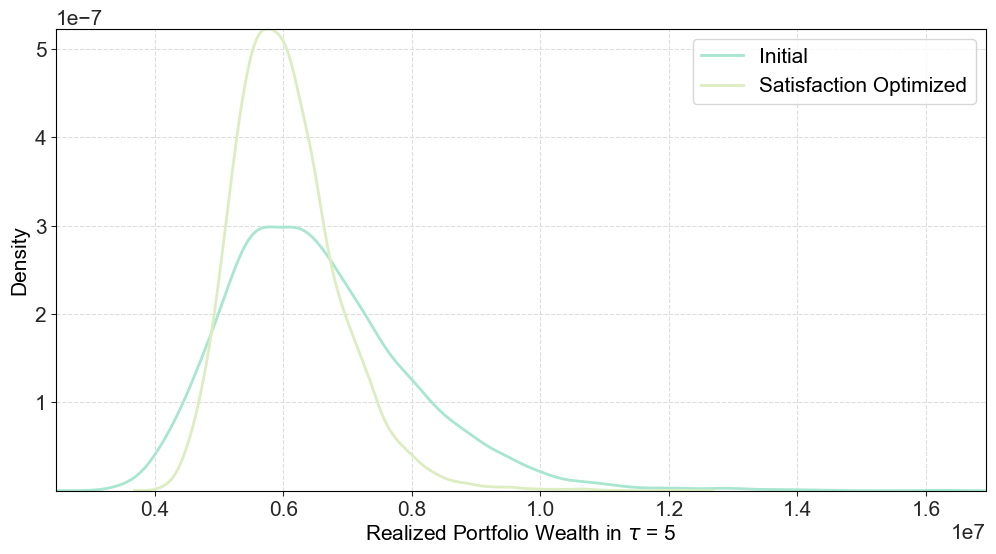

In [64]:
# calculate portfolio returns
#initial = (sim_data_new[:, :, :] * opt_port_weights[:, None, :]).sum(axis=2)
#opt_buy_and_hold_index = (sim_data_new[:, :, :] * opt_port_weights_constraints[:, None, :]).sum(axis=2)

fig, ax = plt.subplots(figsize=(12, 6))
#sns.kdeplot(np.mean(init_buy_and_hold_index, axis=0), label="Initial");
#sns.kdeplot(np.mean(opt_buy_and_hold_index, axis=0), label="Satisfaction Optimized");
sns.kdeplot(init_buy_and_hold_index[:,-1], label="Initial");
sns.kdeplot(opt_buy_and_hold_index[:,-1], label="Satisfaction Optimized");
#ax.plot([0.05, 0.05], [0, 35], color="red")
#ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel("Realized Portfolio Wealth in $τ$ = 5");
ax.legend();

### How can we calculate the risk contribution of each asset using standard deviation and CVAR of final wealth?
### Perform the calculations and comment 

## Marginal Risk Contribution With Volatility as measure

In [66]:
init_pf_vol = portfolio_std(alpha0_w,Sigma_5y_l)
print(init_pf_vol)
opt_pf_vol = portfolio_std(opt_alpha_w, Sigma_5y_l)
print(opt_pf_vol)

0.2898235189245655
0.1690555968951806


In [68]:
#Relative Risk Contribution
#MRC_vol = calculate_risk_contributions_std(opt_alpha,Sigma_5y_l,True)

#Risk Contribution
MRC_vol = calculate_risk_contributions_std(opt_alpha_w,Sigma_5y_l)
np.round((100*MRC_vol),2)

array([0.67, 0.6 , 0.  , 1.33, 0.  , 0.  , 8.91, 3.46, 1.94, 0.  ])

In [69]:
MRC_vol.sum()

0.16905559689518063

In [1437]:
round(pd.DataFrame(opt_alpha).T,2)

,0,1,2,3,4,5,6,7,8,9
0,2245432.35,450563.48,0.49,366450.52,1.14,0.33,646743.44,634584.28,575813.9,5.0


In [1438]:
print(mu_5y_l@opt_alpha)
print(P0@opt_alpha)

6050000.000000001
4919594.940988022


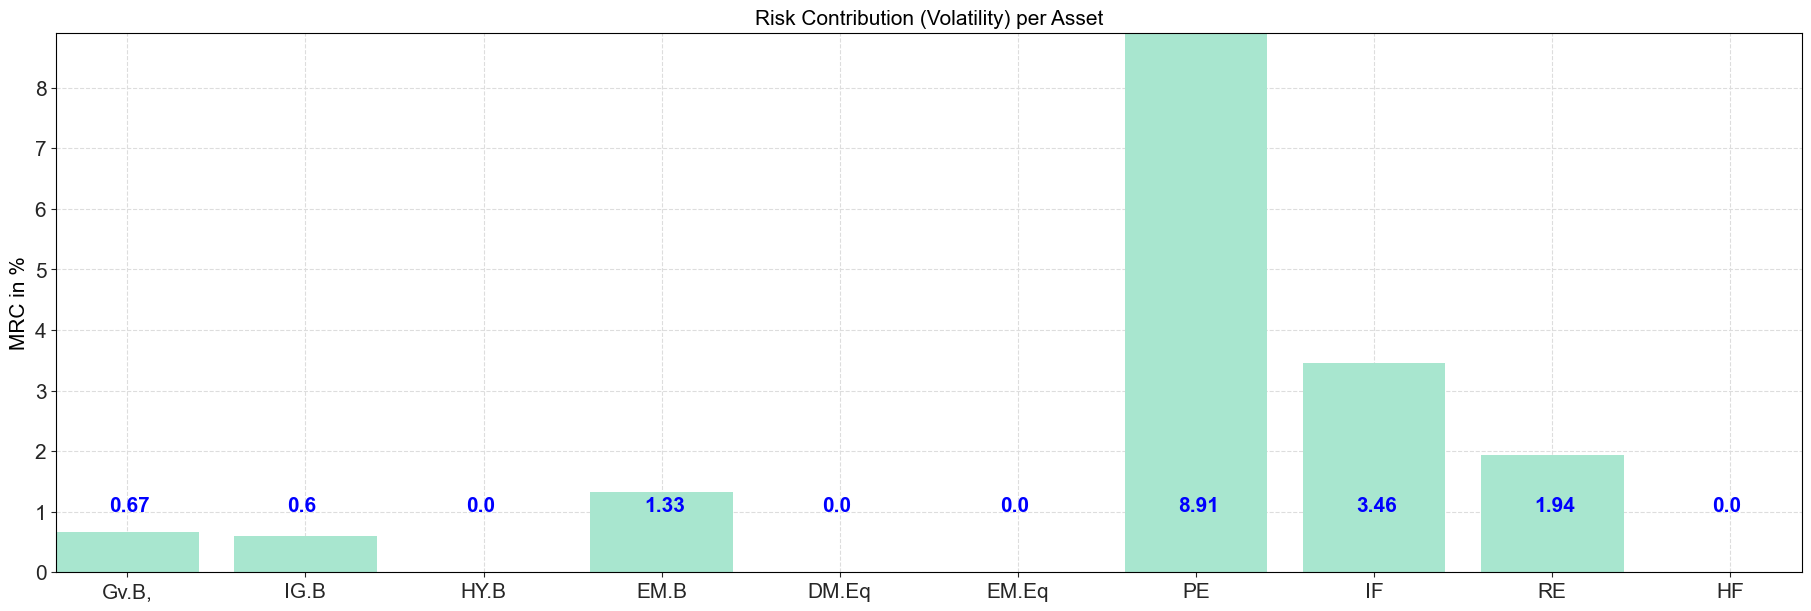

In [70]:
fig, ax = plt.subplots(figsize=(18, 6), layout='constrained')
ax.bar(asset_list, MRC_vol*100);
ax.set_ylabel("MRC in %");
ax.set_title("Risk Contribution (Volatility) per Asset", size=15)
for i, z in enumerate(MRC_vol):
    ax.text(i-0.1,1, round(z*100,2), color='blue', fontweight='bold')

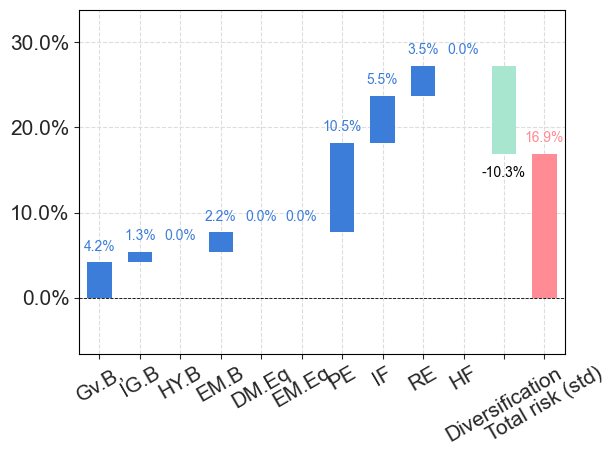

In [71]:
risk_waterfall_chart(np.sqrt(np.diag(Sigma_5y_l))*opt_alpha_w*100, opt_pf_vol*100, names=list(asset_list),
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification");

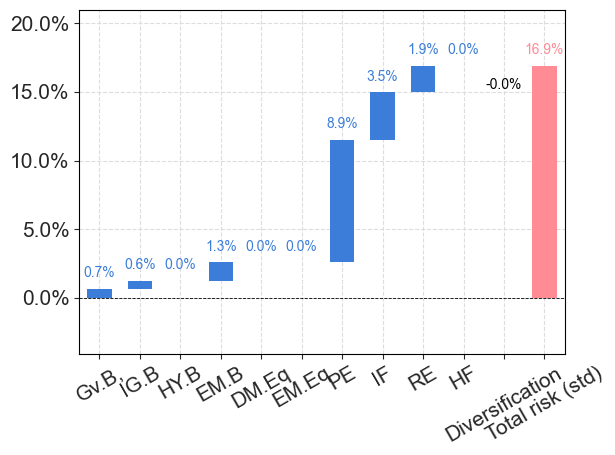

In [72]:
risk_waterfall_chart(MRC_vol*100, opt_pf_vol*100, names=list(asset_list),
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification");

### Risk Waterfall -- Diversification

In [73]:
Sigma_5y_l@opt_alpha_w*100

array([ 0.24758574,  1.09876401,  4.15168339,  3.01195968,  6.07247042,
        9.1193766 , 11.44379026,  4.53365425,  2.79950462,  3.02299262])

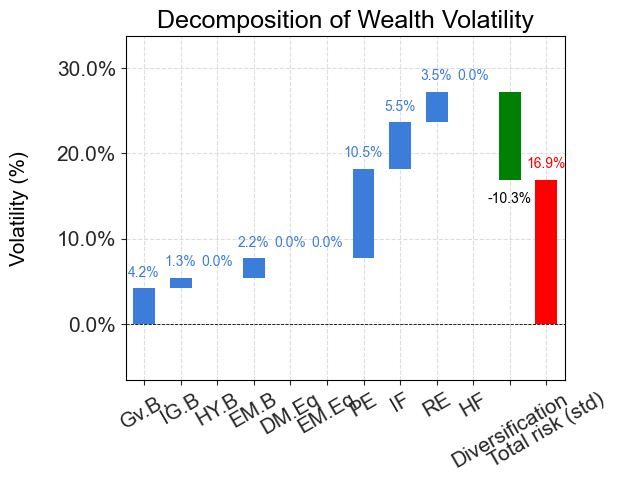

In [74]:
"""
Plot a waterfall chart with risk decomposition 
"""
risk_waterfall_chart(np.sqrt(np.diag(Sigma_5y_l))*opt_alpha_w*100, opt_pf_vol*100, names=list(asset_list),
                     formatting='{:,.1f}%', total_risk_label="Total risk (std)", diversification_label="Diversification"
                     ,title = 'Decomposition of Wealth Volatility', ylabel = 'Volatility (%)'
                     #, xlabel = 'Assets'
                  #    ,risk_color = 'blue'
                  #   , diversification_color = 'green'
                     ,total_risk_color = 'red'
                  #   ,pos_text_color = 'blue'
                    ,diversification_color = 'green'
                    , neg_text_color = 'green'
                     );
                     


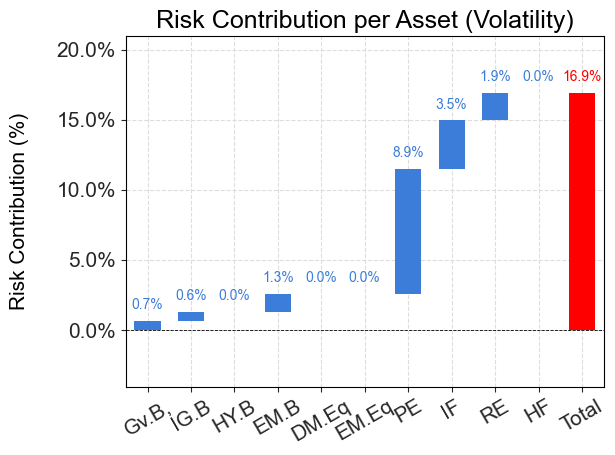

In [75]:
"""
Plot a waterfall chart with risk decomposition 
"""

waterfall_chart(asset_list, MRC_vol*100,formatting='{:,.1f}%'
, title="Risk Contribution per Asset (Volatility)", ylabel = "Risk Contribution (%)"
#, positive_color = 'blue',pos_text_color = 'blue' ,total_color = 'red'
,total_color = 'red');

## CVaR95

In [76]:
init_value_at_risk = np.percentile(init_buy_and_hold_index[:, -1], 5)
init_cond_value_at_risk = np.mean(init_buy_and_hold_index[:, -1][init_buy_and_hold_index[:, -1] <= init_value_at_risk])
round(init_cond_value_at_risk,2)

4229822.6

In [77]:
opt_value_at_risk = np.percentile(opt_buy_and_hold_index[:, -1], 5)
opt_cond_value_at_risk = np.mean(opt_buy_and_hold_index[:, -1][opt_buy_and_hold_index[:, -1] <= opt_value_at_risk])
round(opt_cond_value_at_risk,2)

4700625.09

In [78]:
MRC_cvar = calculate_risk_contributions_cvar(opt_alpha, sim_asset_prices[:,-1,:])
np.int0(MRC_cvar)

array([2345661,  434289,       0,  326866,       0,       0,  505898,
        557775,  530126,       4])

In [79]:
MRC_cvar.sum()

4700625.088153362

In [80]:
print(np.round(calculate_risk_contributions_cvar(opt_alpha_w, sim_asset_prices[:,-1,:]),2))
print(np.round(calculate_risk_contributions_cvar(opt_alpha, sim_asset_prices[:,-1,:], scale = True),2))

[0.48 0.09 0.   0.07 0.   0.   0.1  0.11 0.11 0.  ]
[0.5  0.09 0.   0.07 0.   0.   0.11 0.12 0.11 0.  ]


In [1710]:
np.int0(MRC_cvar)

array([2335158,  433143,       0,  327785,       0,       0,  520686,
        546909,  531951,       4])

In [1809]:
calculate_risk_contributions_cvar(opt_alpha, sim_asset_prices[:,-1,:]).sum()

4695641.754030387

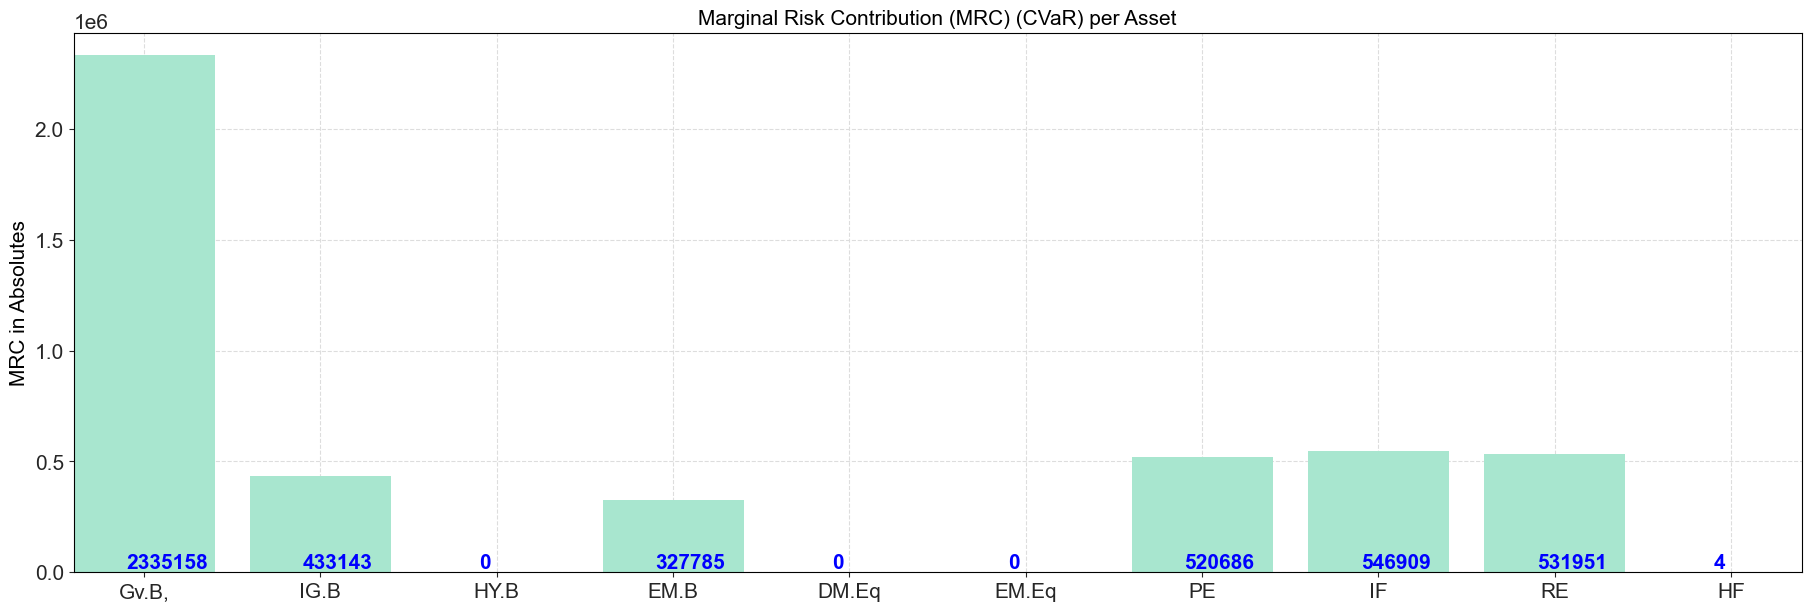

In [1871]:
fig, ax = plt.subplots(figsize=(18, 6), layout='constrained')
ax.bar(asset_list, MRC_cvar);
ax.set_ylabel("MRC in Absolutes");
ax.set_title("Marginal Risk Contribution (MRC) (CVaR) per Asset", size=15)
ax.set_ylim(0,max(MRC_cvar)+100000);
for i, z in enumerate(MRC_cvar):
    ax.text(i-0.1,20000, int(z), color='blue', fontweight='bold')

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='\n', ylabel='\n'>)

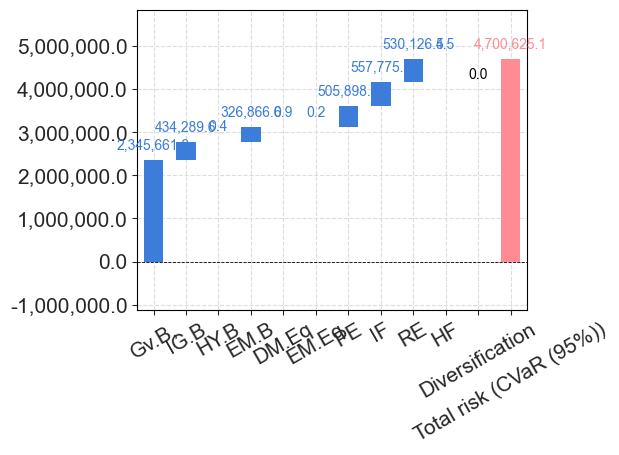

In [81]:
"""
Plot a waterfall chart with risk decomposition 
"""
#opt_div_benefit = opt_pf_vol - opt_alpha_w @ v
#risk_waterfall_chart(MRC_vol, opt_pf_vol*100, names=asset_list,
risk_waterfall_chart(MRC_cvar, MRC_cvar.sum(), names=list(asset_list),
                     formatting='{:,.1f}', total_risk_label="Total risk (CVaR (95%))")#, diversification_label="Diversification");



(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='\n', ylabel='\n'>)

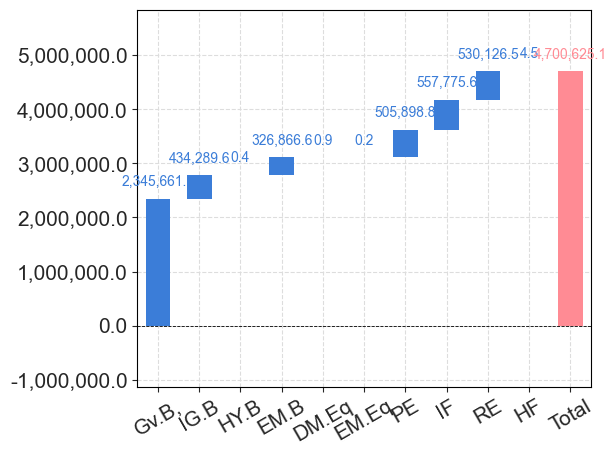

In [82]:
"""
Plot a waterfall chart with risk decomposition 
"""
#opt_div_benefit = opt_pf_vol - opt_alpha_w @ v
#risk_waterfall_chart(MRC_vol, opt_pf_vol*100, names=asset_list,
waterfall_chart(asset_list, MRC_cvar,formatting='{:,.1f}', label="Total risk (CVaR (95%))")
#waterfall_chart(MRC_cvar, MRC_cvar.sum(), names=list(asset_list),
#                     formatting='{:,.1f}', total_risk_label="Total risk (CVaR (95%))")#, diversification_label="Diversification");



## VaR & CVaR Histogram

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Total Risk Contribution (CVaR (95%))'}, xlabel='\n', ylabel='\n'>)

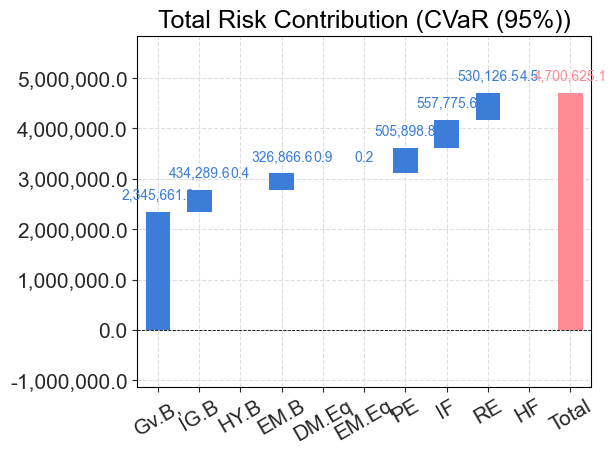

In [83]:
waterfall_chart(asset_list, MRC_cvar,formatting='{:,.1f}', title="Total Risk Contribution (CVaR (95%))")

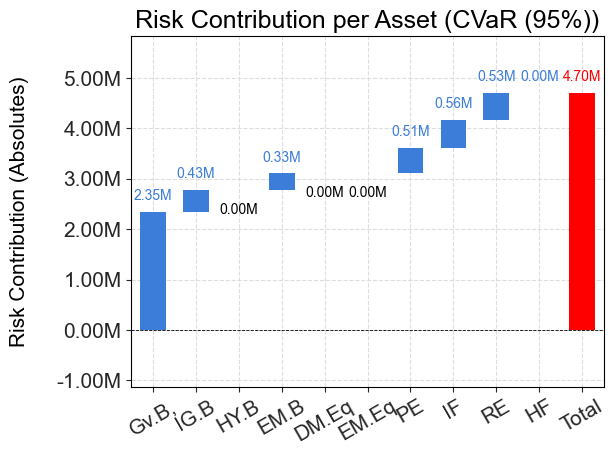

In [84]:
"""
Plot a waterfall chart with risk decomposition 
"""
fig_CVaR = waterfall_chart(asset_list, np.int0(MRC_cvar)/1000000,formatting='{:,.2f}M'
, title="Risk Contribution per Asset (CVaR (95%))", ylabel = "Risk Contribution (Absolutes)"
 ,negative_color = 'black'
 ,total_color = 'red'
);

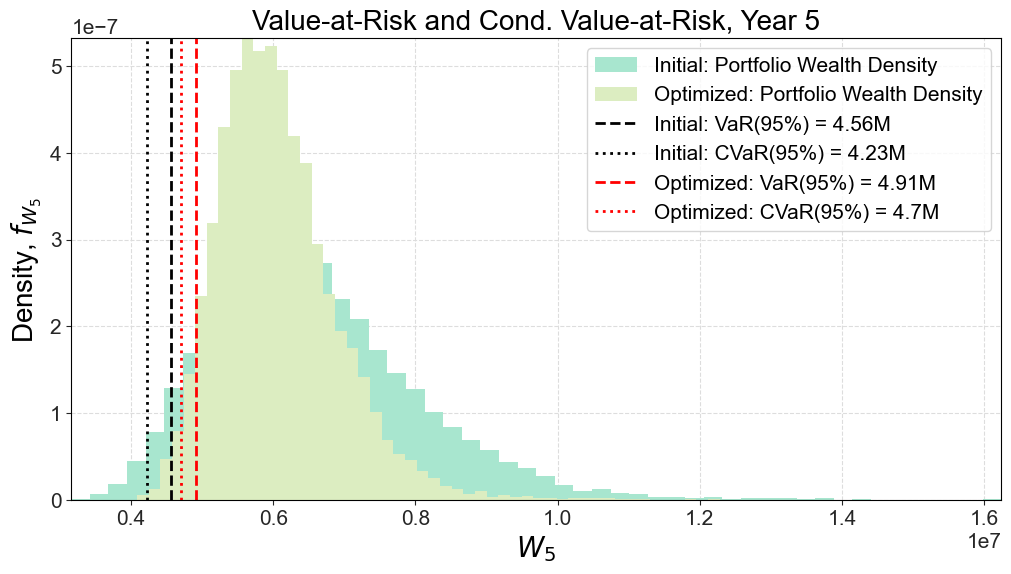

In [85]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(init_buy_and_hold_index[:,-1], density=True, bins=50, label= "Initial: Portfolio Wealth Density");
ax.hist(opt_buy_and_hold_index[:,-1], density=True, bins=50, label= "Optimized: Portfolio Wealth Density");

ax.axvline(init_value_at_risk, ymin=0, ymax=8, linestyle = "--",color="black", label = "Initial: VaR(95%) = {}M".format(np.round(init_value_at_risk/1000000,2)))
ax.axvline(init_cond_value_at_risk, ymin=0, ymax=8, linestyle = "dotted", color="black", label = "Initial: CVaR(95%) = {}M".format(np.round(init_cond_value_at_risk/1000000,2)))
ax.axvline(opt_value_at_risk, ymin=0, ymax=8, linestyle = "--",color="red", label = "Optimized: VaR(95%) = {}M".format(np.round(opt_value_at_risk/1000000,2)))
ax.axvline(opt_cond_value_at_risk, ymin=0, ymax=8, linestyle = "dotted", color="red", label = "Optimized: CVaR(95%) = {}M".format(np.round(opt_cond_value_at_risk/1000000,2)))
ax.set_title("Value-at-Risk and Cond. Value-at-Risk, Year 5", size=20)
ax.set_xlabel('$W_5$', size=20)
ax.set_ylabel('Density, $f_{W_5}$', size=20);
ax.legend();
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# add text
#text_to_add = "$\mathbf{VaR}_{Init 0.05}" + " = {:,.1f}\%$".format(-init_value_at_risk)
#ax.text(-0.5, 1.0, text_to_add, rotation=90);

#text_to_add_2 =  "$\mathbf{CVaR}_{Init 0.05}" + " = {:,.1f}\%$".format(-init_cond_value_at_risk)
#ax.text(5*10**6, 1.0, text_to_add_2,rotation=90);

#text_to_add =  "$\mathbf{VaR}_{Opt 0.05}" + " = {:,.1f}\%$".format(-opt_value_at_risk)
#ax.text(5*10**6, 1.0, text_to_add, rotation=90);

#text_to_add_2 =  "$\mathbf{CVaR}_{Opt 0.05}" + " = {:,.1f}\%$".format(-opt_cond_value_at_risk)
#ax.text(5*10**6, 1.0, text_to_add_2,rotation=90);


# x-axis a percent
#xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
#ax.xaxis.set_major_formatter(xticks)